# Sistem Rekomendasi Destinasi Wisata Berbasis Collaborative Filtering
<hr>


## 1. Mengimpor Library Python yang Dibutuhkan

In [ ]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [ ]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3. Data Understanding

### 3.1 Menyiapkan Data

In [ ]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('tourism_rating.csv')
place = pd.read_csv('tourism_with_id.csv')
user = pd.read_csv('user.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'tourism_rating.csv'

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [ ]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

In [ ]:
place.info()

In [ ]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [ ]:
# melihat gambaran data rating

rating.head()

In [ ]:
rating.info()

In [ ]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Kota Bandung

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

In [ ]:
# Melihat ukuran dataset rating untuk Kota Bandung

rating.shape

#### 3.2.3. Data user

In [ ]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
18,2,"Bekasi, Jawa Barat",21
345,3,"Cirebon, Jawa Barat",23
62,4,"Bekasi, Jawa Barat",21
63,5,"Lampung, Sumatera Selatan",20


In [ ]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata di Kota Bandung

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

In [ ]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

## 4. Eksplorasi Data

In [ ]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10 = pd.merge(top_10, place[['Place_Id','Place_Name']], how='left', left_on='index', right_on='Place_Id')

# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8,5))
sns.barplot('Place_Id_x', 'Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Jumlah Rating')
plt.xlabel('Nama Lokasi')
plt.show()

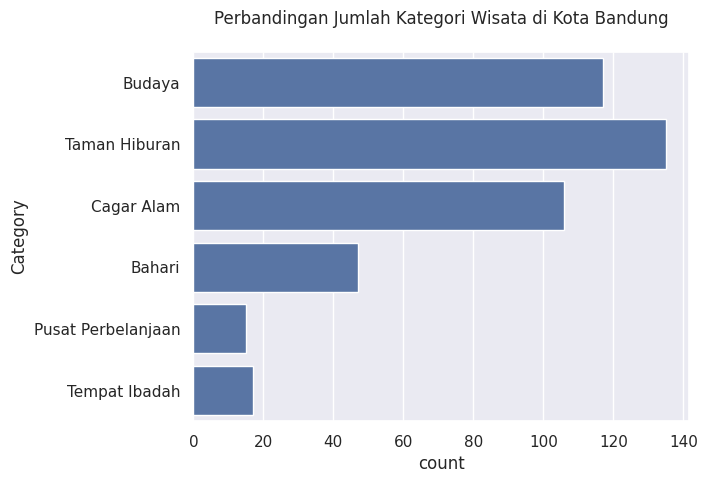

In [ ]:
# Membuat visualisasi jumlah kategori wisata di Kota Bandung

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata di Kota Bandung', pad=20)
plt.show()

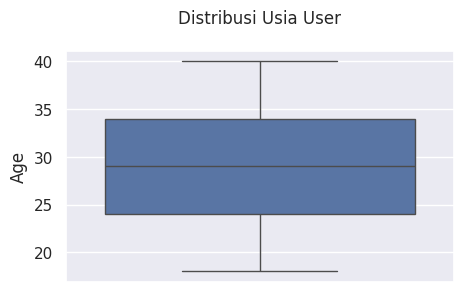

In [ ]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

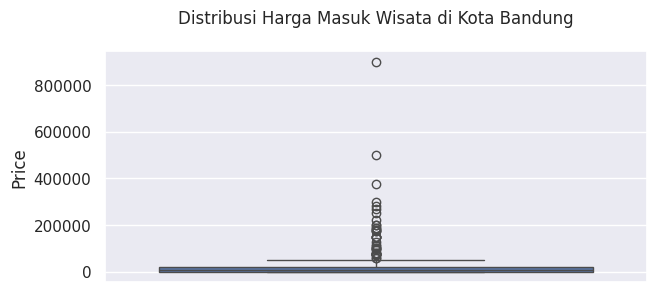

In [ ]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata di Kota Bandung', pad=20)
plt.show()

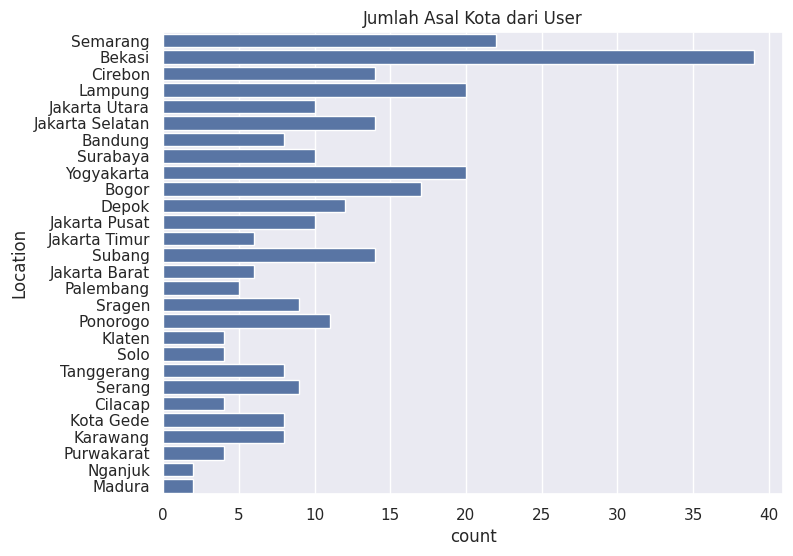

In [ ]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()